# Introduction

I manually labelled the dataset given to me, mapping each transaction into the various buckets/categories.

In [183]:
#Import relevant libraries

import pandas as pd
import nltk

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

In [184]:
#load the annotated CSV file
data =  pd.read_csv('~/Downloads/data1.csv')

data.head() 


,Unnamed: 0,TRANSACTION DATE,PARTICULARS,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,Classification
0,0,1/1/2019,POS XX ASTER MEDICITY POS DEBIT,700.0,NaN,438245.77,Health
1,1,1/1/2019,POS XX WESTSIDE POS DEBIT,7291.0,NaN,430954.77,Shopping
2,2,1/1/2019,POS XX EASY DAY POS DEBIT,208.0,NaN,430746.77,Shopping
3,3,2/1/2019,PAYTMWALLETLOADING,2000.0,NaN,428746.77,Online Transaction
4,4,2/1/2019,TPT RENT,11838.0,NaN,416908.77,Housing


In [185]:
data.Classification.value_counts()

Health                 26
Entertainment          22
Online Transaction     16
Shopping               16
Food                   15
Miscellaneous          14
Investment             11
Transfer                9
Transport               9
Atm withdrawal          8
Housing                 7
Utilities               4
Payment link            3
Tax                     3
Education               2
Groceries               2
Overdraft Repayment     2
Bank Charges            2
Personal Care           2
Savings                 1
Phone & Internet        1
Travel                  1
Name: Classification, dtype: int64

Filter out categories that have less than 7 annotated entries

In [186]:

indices_of_interest = data['Classification'].value_counts()[data['Classification'].value_counts() >= 7 ].index

In [187]:
df = data[data["Classification"].isin(indices_of_interest)]
df = df.drop(['Unnamed: 0', 'TRANSACTION DATE', 'WITHDRAWAL AMT','DEPOSIT AMT','BALANCE AMT'], axis=1)

In [188]:
indices_of_interest

Index(['Health', 'Entertainment', 'Online Transaction', 'Shopping', 'Food',
       'Miscellaneous', 'Investment', 'Transfer', 'Transport',
       'Atm withdrawal', 'Housing'],
      dtype='object')

In [189]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(list(df["Classification"]))

LabelEncoder()

In [190]:
df["Classification (encoded)"] = le.transform(df["Classification"])
df.head()

,PARTICULARS,Classification,Classification (encoded)
0,POS XX ASTER MEDICITY POS DEBIT,Health,3
1,POS XX WESTSIDE POS DEBIT,Shopping,8
2,POS XX EASY DAY POS DEBIT,Shopping,8
3,PAYTMWALLETLOADING,Online Transaction,7
4,TPT RENT,Housing,4


# Split data into training and test

In [191]:
raw_train = df.sample(frac=0.8, random_state = 20).sort_index()
raw_train.head()

,PARTICULARS,Classification,Classification (encoded)
0,POS XX ASTER MEDICITY POS DEBIT,Health,3
1,POS XX WESTSIDE POS DEBIT,Shopping,8
2,POS XX EASY DAY POS DEBIT,Shopping,8
4,TPT RENT,Housing,4
5,PHDF BILLDKACTTV,Miscellaneous,6


In [192]:
raw_test = df[~df.index.isin(raw_train.index)]
raw_test.head()

,PARTICULARS,Classification,Classification (encoded)
3,PAYTMWALLETLOADING,Online Transaction,7
6,POS XX ASHWIN PHARMA POS D EBIT,Health,3
7,RD INSTALLMENT JAN,Investment,5
10,NEFT CR SYNB RAMA H C MR ADAR RSH RAMA P,Transfer,9
15,POS XX MEDPLUS OPTIVAL PO S DEBIT,Health,3


In [193]:
print(f"training entries: {len(raw_train)}")
print(f"test entries: {len(raw_test)}")
print(f"number of unique categories (with enough annotations): {len(set(df['Classification']))}")

training entries: 122
test entries: 31
number of unique categories (with enough annotations): 11


<AxesSubplot:title={'center':'Classification occurrence'}>

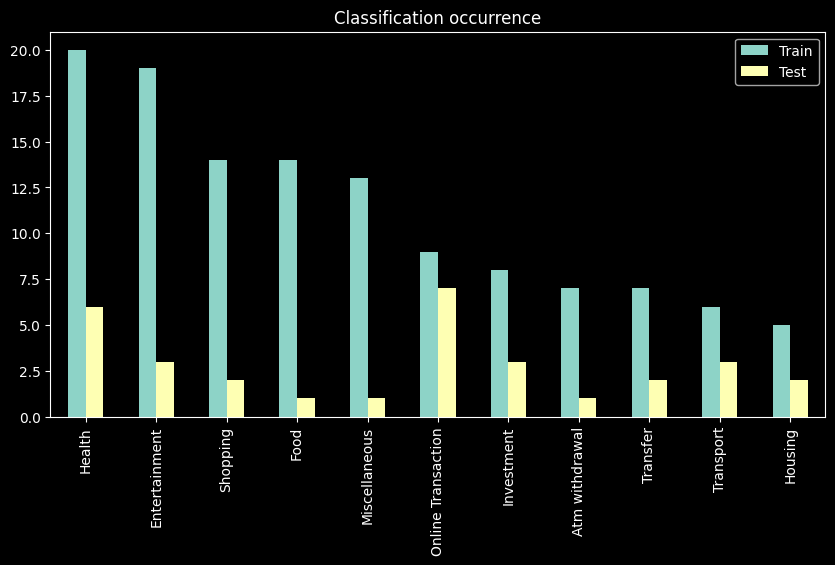

In [194]:
Classification_count_df = pd.concat([
    raw_train["Classification"].value_counts(),
    raw_test["Classification"].value_counts()], 
    axis=1, 
    sort=False,
    keys = ["Train", "Test"])
Classification_count_df.plot(kind="bar", figsize=(10,5), title="Classification occurrence")

Create a bag of words using a count vectorizer

In [195]:
from sklearn.feature_extraction.text import CountVectorizer

desc_vectorizer = CountVectorizer(analyzer="word", max_features=200)

training_bag_of_words = desc_vectorizer.fit_transform(raw_train["PARTICULARS"])

x_train = pd.DataFrame(training_bag_of_words.toarray(),
                       columns=[x for x in desc_vectorizer.get_feature_names_out()]).astype(int)

x_train.head()

,aashirvaad,adar,advance,adyar,akshay,altafahmedguttewalle,amazonseller,amount,ananda,and,...,tpt,tr,uber,uharsh,upi,venkateshwar,westside,world,xx,xxbb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
test_bag_of_words = desc_vectorizer.transform(raw_test["PARTICULARS"])

x_test = pd.DataFrame(test_bag_of_words.toarray(),
                      columns=[x for x in desc_vectorizer.get_feature_names_out()]).astype(int)
x_test.head()

,aashirvaad,adar,advance,adyar,akshay,altafahmedguttewalle,amazonseller,amount,ananda,and,...,tpt,tr,uber,uharsh,upi,venkateshwar,westside,world,xx,xxbb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [197]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (122, 200)
Shape of x_test: (31, 200)


# Model building

# Random Forest

In [198]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, raw_train["Classification (encoded)"])

RandomForestClassifier()

# XGBOOST

In [199]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, raw_train["Classification (encoded)"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

# Analysis

In [200]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [201]:
# create a function to analyze results of the models
def analysis_result(model_name, 
                    train_prediction,
                    train_target,
                    test_prediction, 
                    test_target):
    results = dict()
    results["model"] = model_name
    results["train_accuracy"] = accuracy_score(train_prediction, train_target)
    results["balanced_train_accuracy"] = balanced_accuracy_score(train_prediction, train_target)
    results["test_accuracy"] = accuracy_score(test_prediction, test_target)
    results["balanced_test_accuracy"] = balanced_accuracy_score(test_prediction, test_target)

    for key, value in results.items():
        if isinstance(value, str):
            print(f"\n{value}")
        else:
            print(f"\t{key}: {'{:.2f}'.format(value)}")
    
    return results

In [202]:
accumulated_results = []

train_pred_rf = rf.predict(x_train)
test_pred_rf = rf.predict(x_test)


accumulated_results.append(analysis_result("Random Forest", 
                                           train_pred_rf, 
                                           raw_train['Classification (encoded)'],
                                           test_pred_rf, 
                                           raw_test['Classification (encoded)']))

train_pred_xgb = xgb.predict(x_train)
test_pred_xgb = xgb.predict(x_test)

accumulated_results.append(analysis_result("XGBoost", 
                                           train_pred_xgb, 
                                           raw_train['Classification (encoded)'],
                                           test_pred_xgb, 
                                           raw_test['Classification (encoded)']))




Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.68
	balanced_test_accuracy: 0.69

XGBoost
	train_accuracy: 0.66
	balanced_train_accuracy: 0.77
	test_accuracy: 0.52
	balanced_test_accuracy: 0.62


/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


<AxesSubplot:title={'center':'Performance of models on predicting train and test data'}, xlabel='model'>

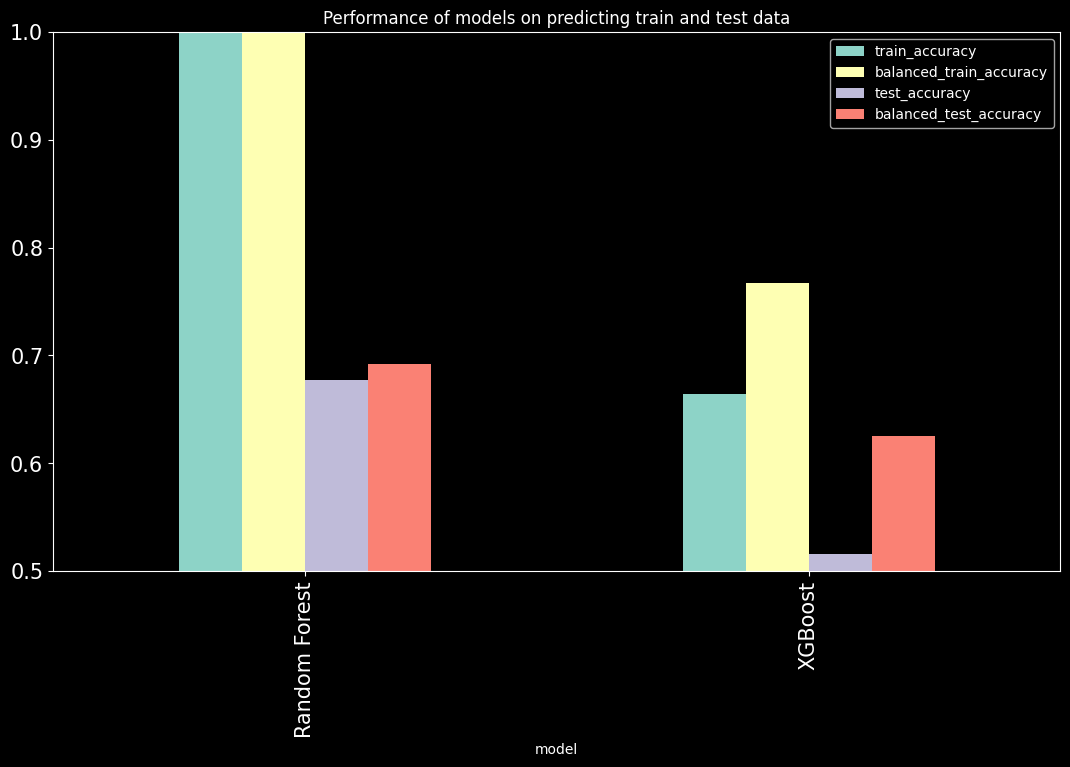

In [203]:
#save accumulated results to a dataframe and plot to visualize results
model_results_df = pd.DataFrame(accumulated_results)
model_results_df.set_index("model").plot(
    kind="bar", figsize=(13,7), ylim=(0.5,1), fontsize=15, 
    title="Performance of models on predicting train and test data"
)

In [204]:
#transform the label encoded classification into the original anotated classification
raw_train.loc[:,"rf_prediction"] = le.inverse_transform(train_pred_rf)
raw_test.loc[:,"rf_prediction"] = le.inverse_transform(test_pred_rf)

raw_train.loc[:,"xgb_prediction"] = le.inverse_transform(train_pred_xgb)
raw_test.loc[:,"xgb_prediction"] = le.inverse_transform(test_pred_xgb)

/var/folders/w7/2mtjz0gj2t7d08xzgrt8k3ph0000gn/T/ipykernel_12265/1746913084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_test.loc[:,"rf_prediction"] = le.inverse_transform(test_pred_rf)
/var/folders/w7/2mtjz0gj2t7d08xzgrt8k3ph0000gn/T/ipykernel_12265/1746913084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_test.loc[:,"xgb_prediction"] = le.inverse_transform(test_pred_xgb)


In [205]:
#select the classification without the label encoded values
view_columns = [x for x in raw_train.keys() if x != "Classification (encoded)"]

In [206]:
raw_train[view_columns].head(30)

,PARTICULARS,Classification,rf_prediction,xgb_prediction
0,POS XX ASTER MEDICITY POS DEBIT,Health,Health,Health
1,POS XX WESTSIDE POS DEBIT,Shopping,Shopping,Shopping
2,POS XX EASY DAY POS DEBIT,Shopping,Shopping,Shopping
4,TPT RENT,Housing,Housing,Miscellaneous
5,PHDF BILLDKACTTV,Miscellaneous,Miscellaneous,Miscellaneous
8,UPI SHAMIM.MOKLES ANK PAY SIMMBA,Miscellaneous,Miscellaneous,Online Transaction
9,POS XX ITUNES.COM BILLPOS DEBIT,Entertainment,Entertainment,Entertainment
11,POS XX BANGALIANA POS DEBI T,Food,Food,Food
12,TECHBIGTREENTERTAIN,Entertainment,Entertainment,Miscellaneous
13,NWD XX SGJ BANGALORE,Atm withdrawal,Atm withdrawal,Atm withdrawal


In [207]:
raw_test[view_columns].head(10)

,PARTICULARS,Classification,rf_prediction,xgb_prediction
3,PAYTMWALLETLOADING,Online Transaction,Online Transaction,Miscellaneous
6,POS XX ASHWIN PHARMA POS D EBIT,Health,Food,Health
7,RD INSTALLMENT JAN,Investment,Transfer,Miscellaneous
10,NEFT CR SYNB RAMA H C MR ADAR RSH RAMA P,Transfer,Transfer,Investment
15,POS XX MEDPLUS OPTIVAL PO S DEBIT,Health,Health,Health
16,POS XX HIGHWAY AUTO. POS DEBIT IT,Transport,Shopping,Food
17,NEFT DR KVBL OWNER KRISHNAJI RAO NETBANK MUM ...,Housing,Housing,Housing
18,POS XX ASTER MEDICITY POS,Health,Health,Health
22,POS XX ASTER MEDICITY POS DEBIT,Health,Health,Health
25,UPI HASSANSUFIYAN AXIS UBEREATS,Transport,Transfer,Online Transaction


# Run everything above again but with Kfold cross validation for better assessment of accuracy

# Split dataset into 7 fold

In [208]:
from sklearn.model_selection import KFold

def split_dataset(x_data,y_data,n_splits):
    # shuffle true is important as the dataset is sorted by alphabetical order of the particular column
    # if shuffle is false then the model will be trained on data very different to that of test
    for train_index, test_index in KFold(n_splits, shuffle=True).split(x_data):
        x_train, x_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        yield x_train,y_train,x_test,y_test
        
cv_dataset = split_dataset(df[["PARTICULARS"]].values,
                           df["Classification (encoded)"].values,
                           7)

In [209]:


overall_results = []

for n, (x_train, y_train, x_test, y_test) in enumerate(cv_dataset):
    print(f"\nProcessing run {n+1}\n")
    run_result = dict() # to store results
    
    # create count vectorizer and apply to train data
    run_result["desc_vectorizer"] = CountVectorizer(analyzer="word", max_features=200)
    training_bag_of_words = run_result["desc_vectorizer"].fit_transform([x[0] for x in x_train])
    x_train_count_vectorised = pd.DataFrame(
        training_bag_of_words.toarray(),
        columns=[x for x in run_result["desc_vectorizer"].get_feature_names_out()]).astype(int)
    
    # apply count vectorizer to test data
    test_bag_of_words = run_result["desc_vectorizer"].transform([x[0] for x in x_test])
    x_test_count_vectorised = pd.DataFrame(
        test_bag_of_words.toarray(),
        columns=[x for x in run_result["desc_vectorizer"].get_feature_names_out()]).astype(int)
    
    
    # train random forest model
    run_result["rf"] = RandomForestClassifier()
    run_result["rf"].fit(x_train_count_vectorised, y_train)
    
    # train xgboost model
    run_result["xgb"] = XGBClassifier()
    run_result["xgb"].fit(x_train_count_vectorised, y_train)
    
    
        # analyse
    accumulated_results = []


    train_pred_rf = run_result["rf"].predict(x_train_count_vectorised)
    test_pred_rf = run_result["rf"].predict(x_test_count_vectorised)

    accumulated_results.append(analysis_result("Random Forest", 
                                               train_pred_rf, 
                                               y_train,
                                               test_pred_rf, 
                                               y_test))

    train_pred_xgb = run_result["xgb"].predict(x_train_count_vectorised)
    test_pred_xgb = run_result["xgb"].predict(x_test_count_vectorised)

    accumulated_results.append(analysis_result("XGBoost", 
                                               train_pred_xgb, 
                                               y_train,
                                               test_pred_xgb, 
                                               y_test))
    
    # reconstruct df for overview later
    df_train = pd.concat(
        [pd.DataFrame(x_train, columns=["PARTICULARS"]), 
         pd.Series(le.inverse_transform(y_train), name="Classification")], 
        axis=1
    )

    df_test = pd.concat(
        [pd.DataFrame(x_test, columns=["PARTICULARS"]), 
         pd.Series(le.inverse_transform(y_test), name="Classification")], 
        axis=1
    )



    df_train.loc[:,"rf_prediction"] = le.inverse_transform(train_pred_rf)
    df_test.loc[:,"rf_prediction"] = le.inverse_transform(test_pred_rf)

    df_train.loc[:,"xgb_prediction"] = le.inverse_transform(train_pred_xgb)
    df_test.loc[:,"xgb_prediction"] = le.inverse_transform(test_pred_xgb)
    
    # save results
    run_result["accumulated_results"] = accumulated_results
    run_result["df_train"] = df_train
    run_result["df_test"] = df_test
    
    overall_results.append(run_result)
    



Processing run 1



/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.59
	balanced_test_accuracy: 0.67

XGBoost
	train_accuracy: 0.69
	balanced_train_accuracy: 0.76
	test_accuracy: 0.55
	balanced_test_accuracy: 0.67

Processing run 2



/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.73
	balanced_test_accuracy: 0.80

XGBoost
	train_accuracy: 0.63
	balanced_train_accuracy: 0.70
	test_accuracy: 0.59
	balanced_test_accuracy: 0.56

Processing run 3



/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.59
	balanced_test_accuracy: 0.68

XGBoost
	train_accuracy: 0.66
	balanced_train_accuracy: 0.77
	test_accuracy: 0.55
	balanced_test_accuracy: 0.69

Processing run 4



/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.59
	balanced_test_accuracy: 0.72

XGBoost
	train_accuracy: 0.72
	balanced_train_accuracy: 0.82
	test_accuracy: 0.45
	balanced_test_accuracy: 0.73

Processing run 5



/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.68
	balanced_test_accuracy: 0.70

XGBoost
	train_accuracy: 0.68
	balanced_train_accuracy: 0.77
	test_accuracy: 0.73
	balanced_test_accuracy: 0.74

Processing run 6


Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.68
	balanced_test_accuracy: 0.74

XGBoost
	train_accuracy: 0.69
	balanced_train_accuracy: 0.77
	test_accuracy: 0.45
	balanced_test_accuracy: 0.59

Processing run 7



/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.62
	balanced_test_accuracy: 0.79

XGBoost
	train_accuracy: 0.64
	balanced_train_accuracy: 0.75
	test_accuracy: 0.48
	balanced_test_accuracy: 0.68


/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/chukwuemekaugwu/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Plot KFold cv model results

In [210]:
data_for_plotting = dict()
models = ["Random Forest", "XGBoost"]
metrics = ["train_accuracy","balanced_train_accuracy","test_accuracy","balanced_test_accuracy"]

for metric in metrics:
    data_for_plotting[metric] = dict()
    for model in models:
        data_for_plotting[metric][model] = []
        for result in overall_results:
            for entry in result["accumulated_results"]:
                if entry["model"] == model:
                    data_for_plotting[metric][model].append(entry[metric])

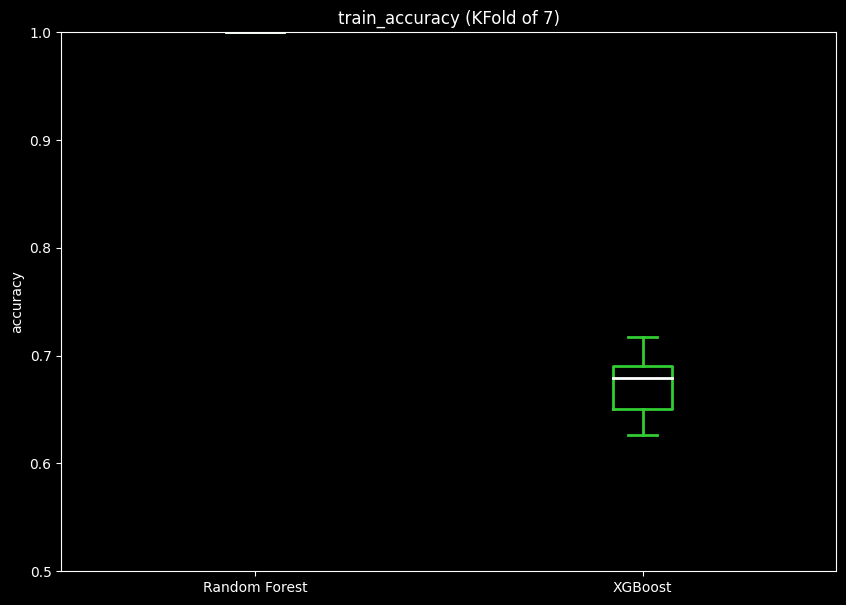

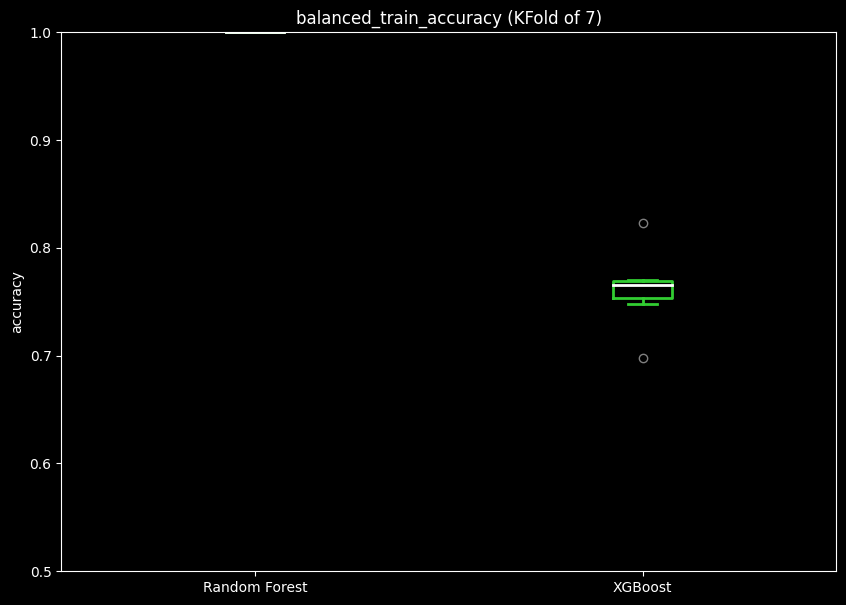

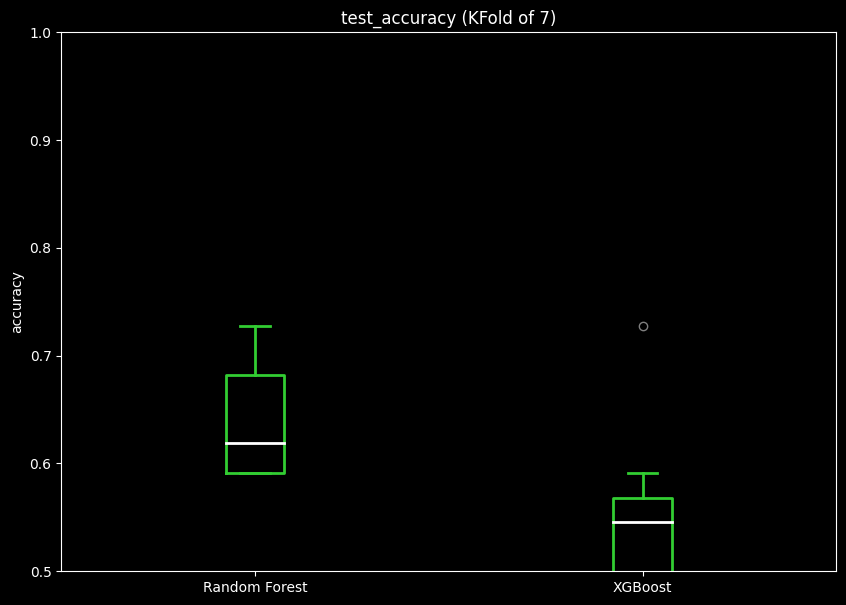

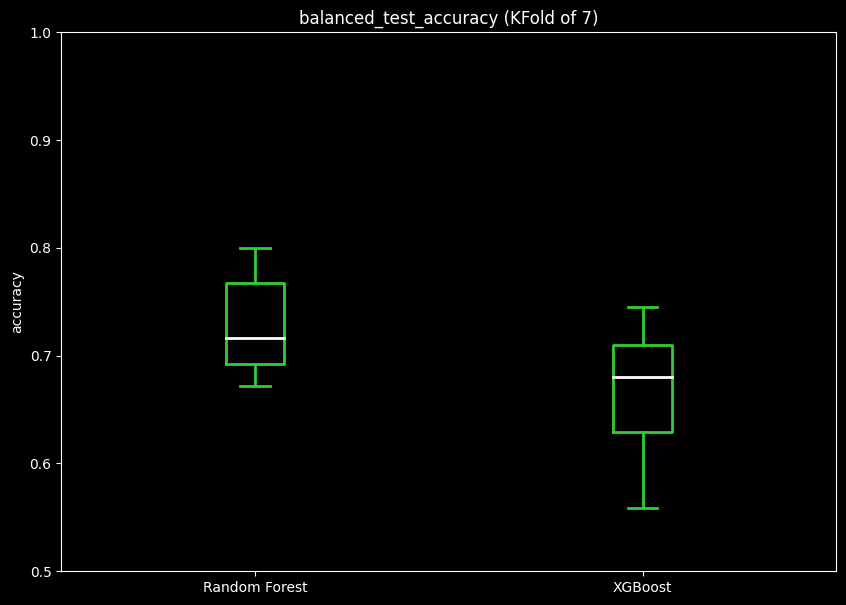

In [211]:
for metric in data_for_plotting:
    labels = []
    data = []
    for model, values in data_for_plotting[metric].items():
        labels.append(model)
        data.append(values)
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_title(f'{metric} (KFold of 7)')
    ax.set_ylim([0.5, 1])
    ax.set_ylabel("accuracy")
    bp = ax.boxplot(data, labels=labels)
    for box in bp['boxes']:
        # change outline color
        box.set( color='limegreen', linewidth=2)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='limegreen', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='limegreen', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='w', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='limegreen', alpha=0.5)

        
    plt.show()

From the analysis and models above, we can see that my model performs very well on training data but not so well on test data because it is overfitted. To solve this, I will need to gather more data and also cross check the applied labels.